# Exponential Smoothing Methods in Time Series Analysis

📌 Exponential smoothing is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.

**Types of Exponential Smoothing:**

  1. **Single Exponential Smoothing**
    
  📌 Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

  📌 It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

  📌 This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

  2. **Double Exponential Smoothing**
  
  📌 Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series.

  📌 In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b).

  📌 The method supports trends that change in different ways: an additive and a multiplicative, depending on whether the trend is linear or exponential respectively.

  📌 Double Exponential Smoothing with an additive trend is classically referred to as Holt’s linear trend model, named for the developer of the method Charles Holt.

    *   **Additive Trend**: Double Exponential Smoothing with a linear trend.
    *   **Multiplicative Trend**: Double Exponential Smoothing with an exponential trend.

  📌 For longer range (multi-step) forecasts, the trend may continue on unrealistically. As such, it can be useful to dampen the trend over time.

  3. **Triple Exponential Smoothing**

  📌 Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.

  📌 This method is sometimes called Holt-Winters Exponential Smoothing, named for two contributors to the method: Charles Holt and Peter Winters.

  📌 In addition to the alpha and beta smoothing factors, a new parameter is added called gamma (g) that controls the influence on the seasonal component.

  📌 As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.

    *  **Additive Seasonality**: Triple Exponential Smoothing with a linear seasonality.
    *  **Multiplicative Seasonality**: Triple Exponential Smoothing with an exponential seasonality.

  📌 Triple exponential smoothing is the most advanced variation of exponential smoothing and through configuration, it can also develop double and single exponential smoothing models.

# Business Problem

📌 Our aim here is to estimate the amount of air pollution (co2) one month later.

# Dataset Story

📌 The carbon dioxide record from Mauna Loa Observatory, known as the “Keeling Curve,” is the world’s longest unbroken record of atmospheric carbon dioxide concentrations. Scientists make atmospheric measurements in remote locations to sample air that is representative of a large volume of Earth’s atmosphere and relatively free from local influences.

Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
Period of Record: March 1958 - December 2001

# Import Necessary Libraries

In [ ]:
import itertools
import warnings
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings("ignore")

# Import Dataset

In [ ]:
data = sm.datasets.co2.load_pandas()
y = data.data
y.head()

,co2
1958-03-29,316.1000
1958-04-05,317.3000
1958-04-12,317.6000
1958-04-19,317.5000
1958-04-26,316.4000


In [ ]:
# Converting Weekly Data to Monthly Data
y = y['co2'].resample('MS').mean()
y.head()

1958-03-01   316.1000
1958-04-01   317.2000
1958-05-01   317.4333
1958-06-01        NaN
1958-07-01   315.6250
Freq: MS, Name: co2, dtype: float64

# Missing Value Analysis

In [ ]:
y.isnull().sum()

5

In [ ]:
# Filling the Missing Values with the Next Value
y = y.fillna(y.bfill())
y.isnull().sum()

0

# Visualizing the Time Series Simply

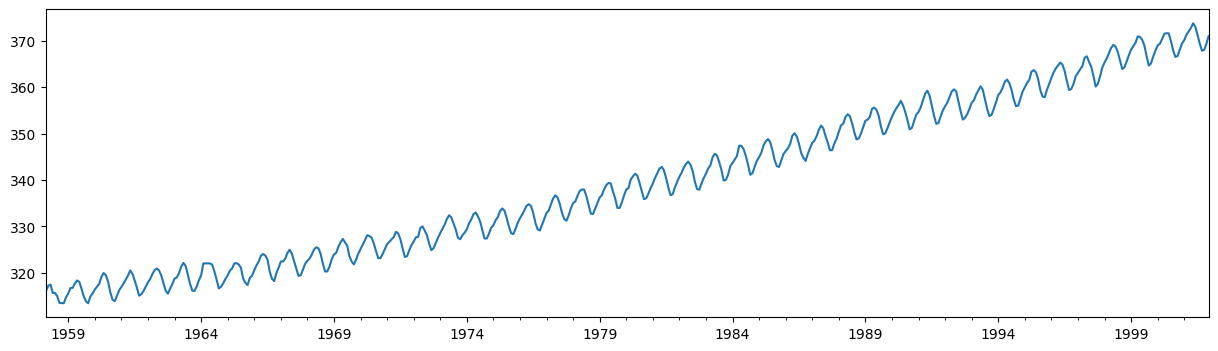

In [ ]:
y.plot(figsize=(15, 4))
plt.show()

# Splitting the Dataset

In [ ]:
# Using Holdut Method ===> Train: 478 Month and Test: 48 Month
train = y[:'1997-12-01']
test = y['1998-01-01':]
print((len(train), len(test)))

(478, 48)


# Time Series Structural Analysis

In [ ]:
def ts_decompose(y, model="additive"):
    
    # Stationary Test: Dickey-Fuller
    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        is_istationary = (F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        is_istationary = (F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].set_title(is_istationary)
    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

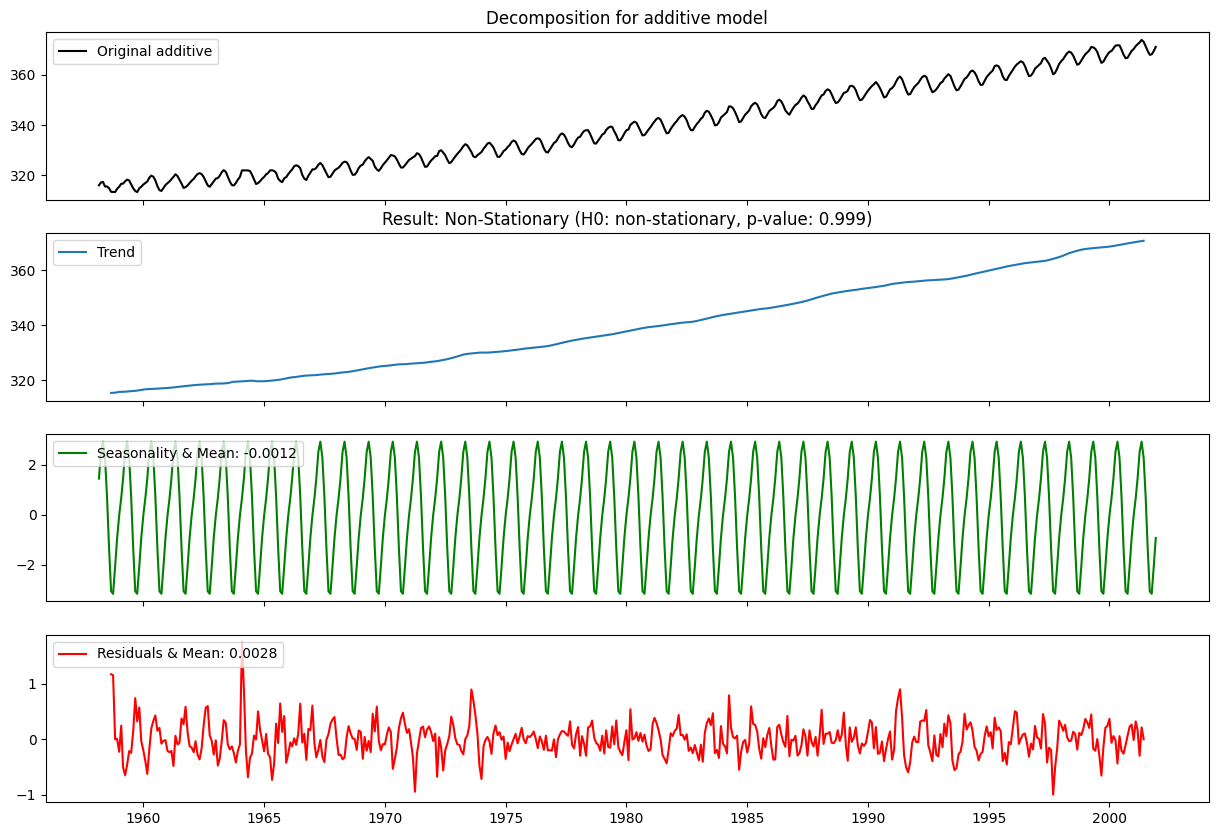

In [ ]:
ts_decompose(y)

# Single Exponential Smoothing

📌 Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

📌 It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

📌 This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

## Create a Base Model Using Single Exponential Smoothing

SES = Level

In [ ]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

In [ ]:
def ses_base_model(train, test, smoothing_level, step, title="Single Exponential Smoothing"):
  ses_model = SimpleExpSmoothing(train).fit(smoothing_level=smoothing_level)
  y_pred = ses_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

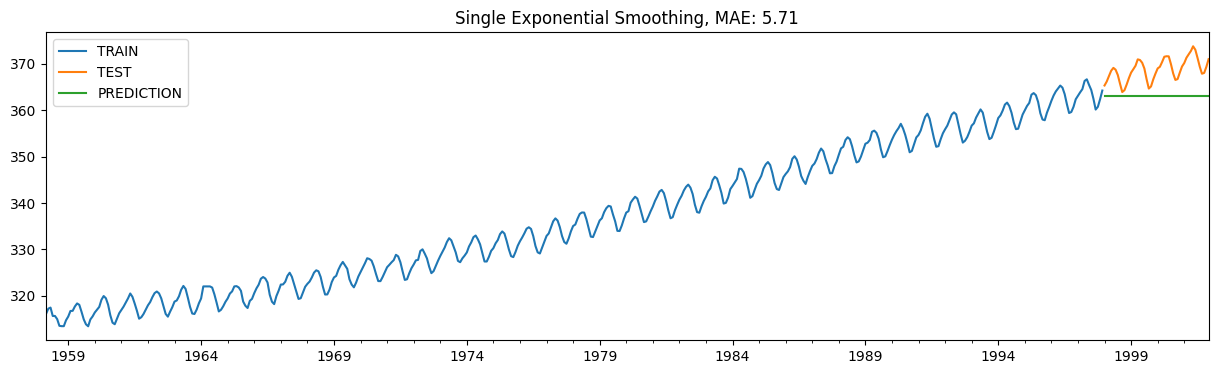

In [ ]:
ses_base_model(train, test, smoothing_level=0.5, step=48)

## Model Tuning - Single Exponential Smoothing

In [ ]:
def ses_optimizer(train, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

In [ ]:
def ses_model_tuning(train , test, step, title="Model Tuning - Single Exponential Smoothing"):
  alphas = np.arange(0.8, 1, 0.01)
  best_alpha, best_mae = ses_optimizer(train, alphas, step=step)
  final_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

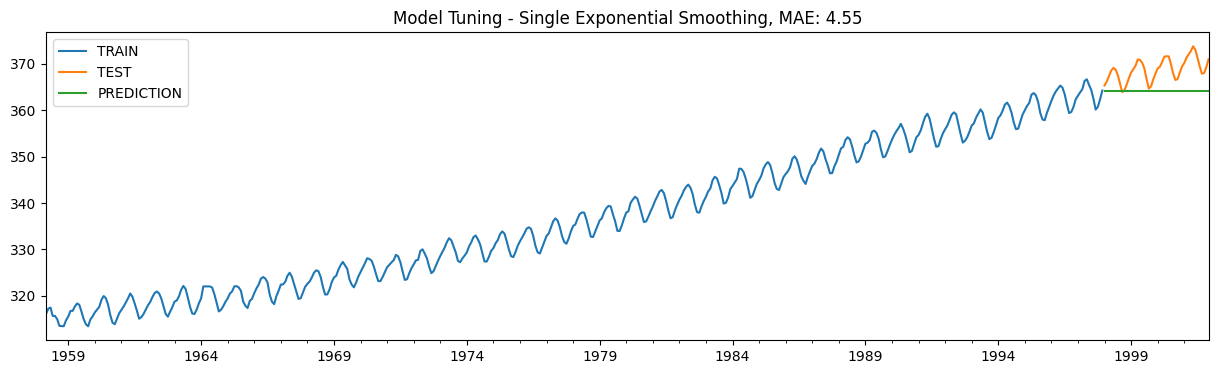

In [ ]:
ses_model_tuning(train, test, step=48)

# Double Exponential Smoothing

📌 Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series.

📌 In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b).

📌 The method supports trends that change in different ways: an additive and a multiplicative, depending on whether the trend is linear or exponential respectively.

📌 Double Exponential Smoothing with an additive trend is classically referred to as Holt’s linear trend model, named for the developer of the method Charles Holt.

  * **Additive Trend**: Double Exponential Smoothing with a linear trend.
  * **Multiplicative Trend**: Double Exponential Smoothing with an exponential trend.

📌 For longer range (multi-step) forecasts, the trend may continue on unrealistically. As such, it can be useful to dampen the trend over time.

## Create a Base Model Using Double Exponential Smoothing

DES = Level(SES) + Trend

In [ ]:
def des_base_model(train, test, trend, smoothing_level, smoothing_trend, step, title="Double Exponential Smoothing"):
  des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_trend)
  y_pred = des_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

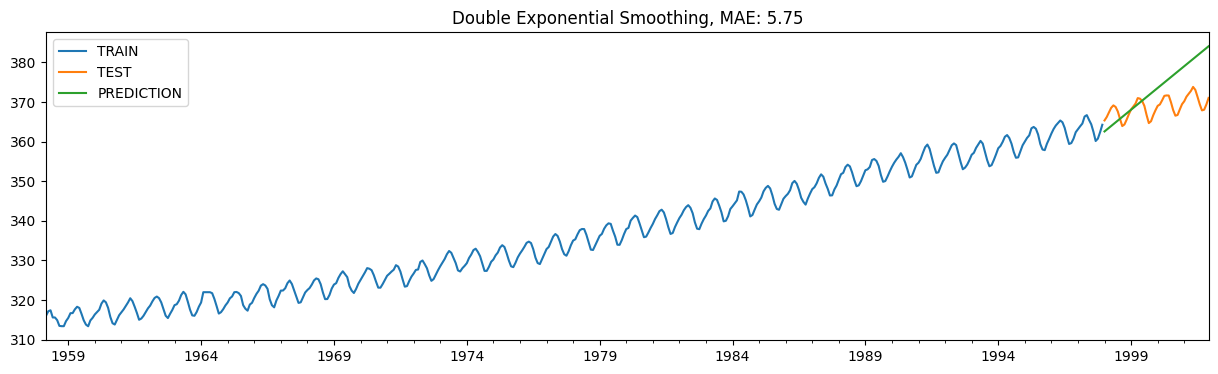

In [ ]:
des_base_model(train, test, trend='add', smoothing_level=0.5, smoothing_trend=0.5, step=48)

## Model Tuning - Double Exponential Smoothing

In [ ]:
def des_optimizer(train, alphas, betas, trend, step):

    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae

    return best_alpha, best_beta, best_mae

In [ ]:
def des_model_tuning(train , test, step, trend, title="Model Tuning - Double Exponential Smoothing"):
  alphas = np.arange(0.01, 1, 0.10)
  betas = np.arange(0.01, 1, 0.10)
  best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, trend=trend, step=step)
  final_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

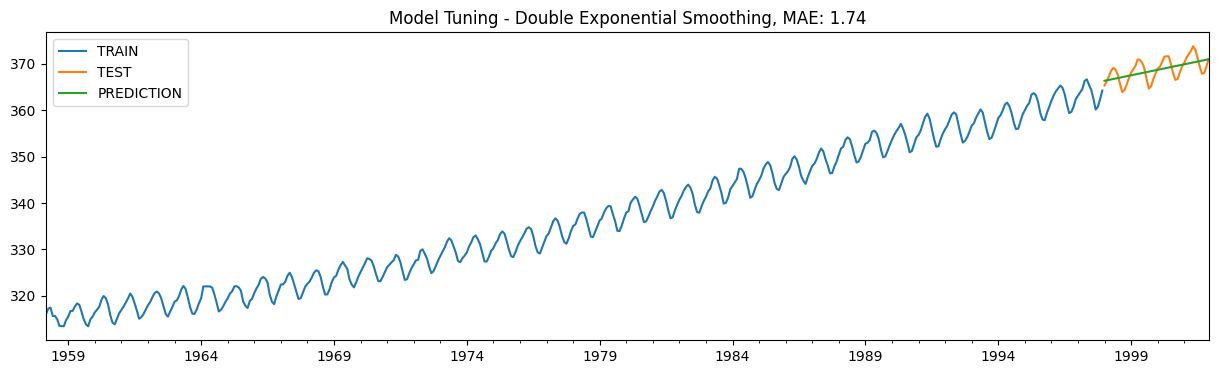

In [ ]:
des_model_tuning(train, test, step=48, trend='add')

# Triple Exponential Smoothing

📌 Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.

📌 This method is sometimes called Holt-Winters Exponential Smoothing, named for two contributors to the method: Charles Holt and Peter Winters.

📌 In addition to the alpha and beta smoothing factors, a new parameter is added called gamma (g) that controls the influence on the seasonal component.

📌 As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.

  *  **Additive Seasonality**: Triple Exponential Smoothing with a linear seasonality.
  *  **Multiplicative Seasonality**: Triple Exponential Smoothing with an exponential seasonality.

📌 Triple exponential smoothing is the most advanced variation of exponential smoothing and through configuration, it can also develop double and single exponential smoothing models.

## Create a Base Model Using Triple Exponential Smoothing

TES = Level(SES) + Trend + Seasonality

or

TES = SES + DES + Seasonality

In [ ]:
def tes_base_model(train, test, trend, seasonal, seasonal_periods, smoothing_level, smoothing_trend, smoothing_seasonal, step, title="Triple Exponential Smoothing"):
  des_model = ExponentialSmoothing(train, 
                                   trend=trend, 
                                   seasonal=seasonal, 
                                   seasonal_periods=seasonal_periods).fit(smoothing_level=smoothing_level, 
                                                                          smoothing_slope=smoothing_trend,
                                                                          smoothing_seasonal=smoothing_seasonal)
  y_pred = des_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

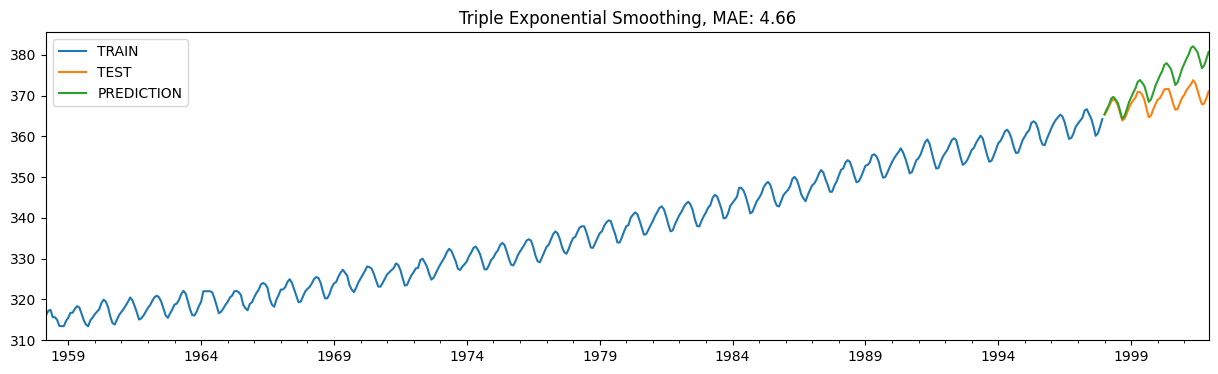

In [ ]:
tes_base_model(train, test, trend='add', seasonal='add', seasonal_periods=12, smoothing_level=0.5, smoothing_trend=0.5, smoothing_seasonal=0.5, step=48)

## Model Tuning - Triple Exponential Smoothing

In [ ]:
def tes_optimizer(train, abg, trend, seasonal,  seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

In [ ]:
def tes_model_tuning(train , test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
  alphas = betas = gammas = np.arange(0.10, 1, 0.10)
  abg = list(itertools.product(alphas, betas, gammas))
  best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg=abg, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, step=step)
  final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)
  return best_alpha, best_beta, best_gamma, best_mae

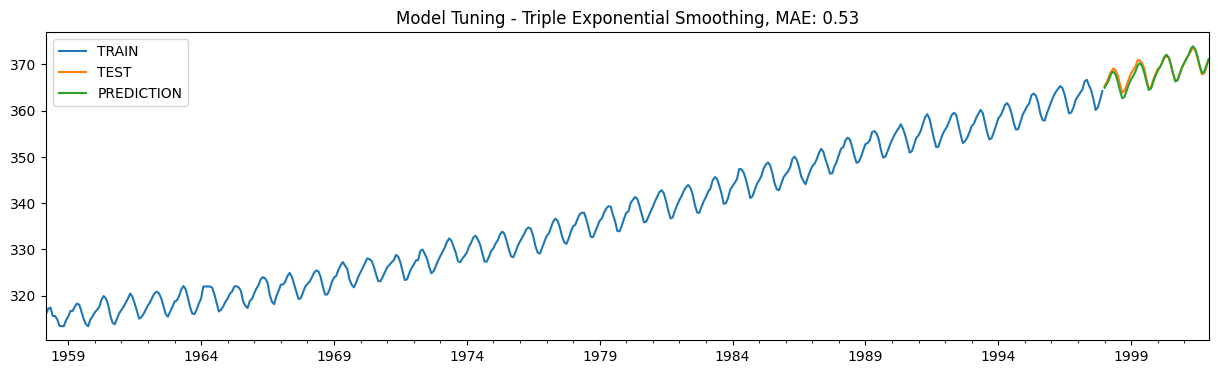

In [ ]:
best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, test, step=48, trend='add', seasonal='add', seasonal_periods=12)

# TES Final Model(Prediction)

In [ ]:
def tes_final_model(y, best_alpha, best_beta, best_gamma, step, trend='add', seasonal='add'):
  final_model = ExponentialSmoothing(y, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
  feature_predict = final_model.forecast(step)
  return feature_predict

In [ ]:
tes_final_model(y, best_alpha, best_beta, best_gamma, step=6)

2002-01-01   371.9092
2002-02-01   372.6892
2002-03-01   373.5971
2002-04-01   374.8035
2002-05-01   375.2977
2002-06-01   374.7064
Freq: MS, dtype: float64